In [1]:
%matplotlib inline

from scipy.misc     import imsave
from keras          import metrics
from PIL            import Image

from keras.models                      import Model
from keras.layers                      import Lambda
from keras.layers                      import Input
from keras.applications.vgg16          import VGG16
from keras.applications.vgg16          import decode_predictions
from keras.utils.np_utils              import to_categorical
from keras.applications.imagenet_utils import CLASS_INDEX

import keras.backend     as K
import numpy             as np
import matplotlib.pyplot as plt

import tqdm 

Using TensorFlow backend.


In [2]:
def limit_mem():
    cfg                          = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config = cfg))

In [3]:
limit_mem()

# Goal

The goal of this notebook is to implement the "fast gradient sign method" presented in [Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572). This method is used to modify classical samples that a deep neural network trained classification will fail to classify properly.

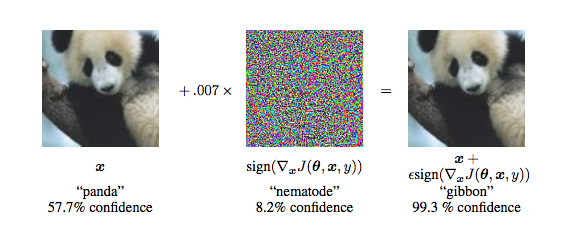

In [4]:
Image.open('images/adv.png')

The idea of this method is to take a well classified sample, compute the gradient for the score for the wrong class for this picture and update its pixels by a small amount in the direction of the gradient.

In [5]:
filename = 'images/dog.jpg'

# VGG loading

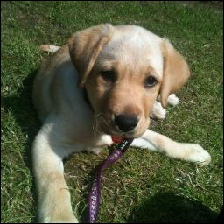

In [6]:
original_pic    = Image.open(filename).resize((224, 224))
original_array  = np.expand_dims(np.array(original_pic), 0)
original_pic

In [7]:
imagenet_mean    = np.array([123.68, 116.779, 103.939], dtype = np.float32)
preprocess       = lambda x: (x - imagenet_mean)[:, :, :, ::-1]
deprocess        = lambda x: (x + imagenet_mean)[:, :, :, ::-1]
inp              = Input(shape = (224, 224, 3)) 
preprocess_layer = Lambda(preprocess)(inp)
model            = VGG16(input_tensor = preprocess_layer)

In [8]:
pred = model.predict(original_array)
print(*[p[1:] for p in decode_predictions(pred)[0]], sep = '\n')

('Labrador_retriever', 0.80970925)
('golden_retriever', 0.071328014)
('beagle', 0.035515532)
('tennis_ball', 0.014304332)
('English_foxhound', 0.009030452)


# Adversarial example generation

Now we try to confuse the network by modifying the dog picture. We take a wrong target, in this case we chose the n-th most probable prediction, and compute the gradient of the loss of this class in function of the input pixels.

In [9]:
def extract_nth_most_probable_idx(model, array, n):
    predictions = model.predict(array)
    sorted_pred = sorted(list(enumerate(predictions[0])), key = lambda x:x[1], reverse = True)
    
    return sorted_pred[n][0]

In [10]:
most_probable_idx = 3
fake_class_idx    = extract_nth_most_probable_idx(model, original_array, most_probable_idx)

In [11]:
fake_target          = to_categorical(fake_class_idx, 1000)
fake_target_variable = K.variable(fake_target)
loss                 = metrics.categorical_crossentropy(model.output, fake_target_variable)
gradients            = K.gradients(loss, model.input)
get_grad_values      = K.function([model.input], gradients)

In [12]:
grad_values = get_grad_values([original_array])[0]

As mentioned in the article, we are just interested in the sign of the gradients.

In [13]:
grad_signs                   = grad_values.copy()
grad_signs[grad_values <  0] = -1
grad_signs[grad_values >= 0] = 1

Now we multiply these values by a very small number and add them to the pixel values of the original image.

mean value of perturbation: 0.0100314
('wire-haired_fox_terrier', 0.33003932)
('tennis_ball', 0.1923435)
('toy_terrier', 0.049518034)
('Italian_greyhound', 0.029032188)
('miniature_schnauzer', 0.019032812)


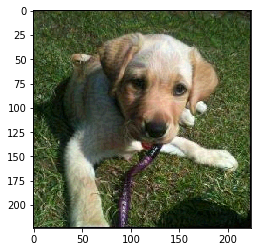

In [14]:
epsilon        = 5
perturbation   = grad_signs * epsilon
modified_array = np.clip(original_array.astype(np.float32) - perturbation, 0., 255.)

print('mean value of perturbation:', perturbation.mean())
plt.imshow(256 - modified_array[0])

pred = model.predict(modified_array)
print(*[p[1:] for p in decode_predictions(pred)[0]], sep = '\n')